# Bias of seasonal forecast

## Import packages

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import regionmask
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot

plt.style.use("seaborn-v0_8-notebook")

## Define Parameters

In [2]:
# Time
year_forecast = 2023
year_start_hindcast = 1993
year_stop_hindcast = 2016

# Variable
variables = [
    "2m_temperature",
    "total_precipitation",
    "surface_solar_radiation_downwards",
    "10m_wind_speed",
    "2m_dewpoint_temperature",
]

# Define centres with missing variables
missing_variables = {"eccc": ["2m_dewpoint_temperature"]}

# Centres
centres = {
    "cmcc": {"system": "35"},
    "dwd": {"system": "21"},
    "eccc": {"system": "3"},
    "ecmwf": {"system": "51"},
    "jma": {"system": "3"},
    "meteo_france": {"system": "8"},
    "ncep": {"system": "2"},
    "ukmo": {"system": "601"},
}
assert all("system" in v for v in centres.values())
assert set(centres) <= {
    "cmcc",
    "dwd",
    "eccc",
    "ecmwf",
    "jma",
    "meteo_france",
    "ncep",
    "ukmo",
}

# Regions
regions = [
    "EAF",
    "ENA",
    "MED",
    "NEB",
    "SAS",
    "SEA",
    "WNA",
    "WSA",
]
assert set(regions) <= set(regionmask.defined_regions.srex.abbrevs)

# Ploting settings
plot_kwargs = {
    "total_precipitation": {"cmap": "BrBG"},
}

## Plot selected regions

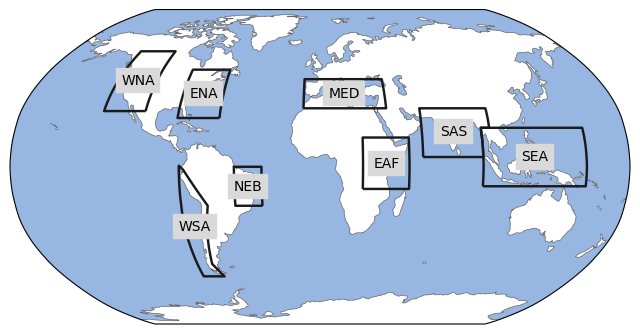

In [3]:
ax = regionmask.defined_regions.srex[regions].plot(
    projection=ccrs.Robinson(),
    label="abbrev",
    add_ocean=True,
)
ax.set_global()

## Define requests

In [4]:
chunks = {"year": 1, "variable": 1}
common_request = {
    "format": "grib",
    "area": [89.5, -179.5, -89.5, 179.5],
    "year": [str(year) for year in range(year_start_hindcast, year_stop_hindcast + 1)],
}

collection_id_reanalysis = "reanalysis-era5-single-levels-monthly-means"
request_reanalysis = common_request | {
    "product_type": "monthly_averaged_reanalysis",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "time": "00:00",
}

collection_id_seasonal = "seasonal-monthly-single-levels"
request_seasonal = common_request | {
    "product_type": "monthly_mean",
    "leadtime_month": list(map(str, range(1, 7))),
    "month": [f"{month:02d}" for month in range(1, 13)],
    "grid": "1/1",
}

## Functions to cache

In [5]:
def regionalised_spatial_weighted_mean(ds, region, weights, mean_dims=None):
    mask = regionmask.defined_regions.srex.mask(ds)
    index = regionmask.defined_regions.srex.map_keys(region)
    ds = ds.where((mask == index).compute(), drop=True)
    ds = diagnostics.spatial_weighted_mean(ds, weights=weights)
    if mean_dims:
        return ds.mean(mean_dims, keep_attrs=True)
    return ds


def postprocess_dataarray(da):
    time_dims = {dim for dim in da.dims if "time" in dim}
    if time_dims:
        if len(time_dims) == 1:
            (valid_time,) = time_dims
        else:
            starting_time = "forecast_reference_time"
            (valid_time,) = time_dims - {starting_time}
            da = da.rename({starting_time: "starting_time"})
        da = da.rename({valid_time: "valid_time"})

    if "leadtime" in da.coords:
        da = da.drop_vars("leadtime")

    # Convert units
    m_to_mm = 1.0e3
    day_to_s = 60 * 60 * 24
    if da.name == "total_precipitation" and da.attrs["units"] != "mm/month":
        if da.attrs["units"] == "m":
            factor = m_to_mm
        elif da.attrs["units"] == "m s**-1":
            factor = m_to_mm * day_to_s
        else:
            raise ValueError(f"{da.attrs['units']=}")

        if "valid_time" in da.variables:
            factor *= da["valid_time"].dt.days_in_month
            units = "mm/month"
        else:
            units = "mm/day"
        with xr.set_options(keep_attrs=True):
            da *= factor
        da.attrs["units"] = units
    return da


def get_seasonal_map(ds, starting_month, valid_month, grid_out, **kwargs):
    starting_time = "forecast_reference_time"
    (valid_dim,) = {dim for dim in ds.dims if "time" in dim} - {starting_time}
    (year,) = set(ds[starting_time].dt.year.values)

    for dim, prefix in {starting_time: "starting", valid_dim: "valid"}.items():
        ds = (
            ds.groupby(f"{dim}.month")
            .mean(keep_attrs=True)
            .rename(month=f"{prefix}_month")
        )
    ds = ds.sel(starting_month=starting_month, valid_month=valid_month)
    ds = ds.mean("realization", keep_attrs=True)

    ds = diagnostics.regrid(ds, grid_out, **kwargs)
    return ds.expand_dims(year=[year])

## Single bias map

100%|██████████| 24/24 [00:02<00:00, 11.75it/s]


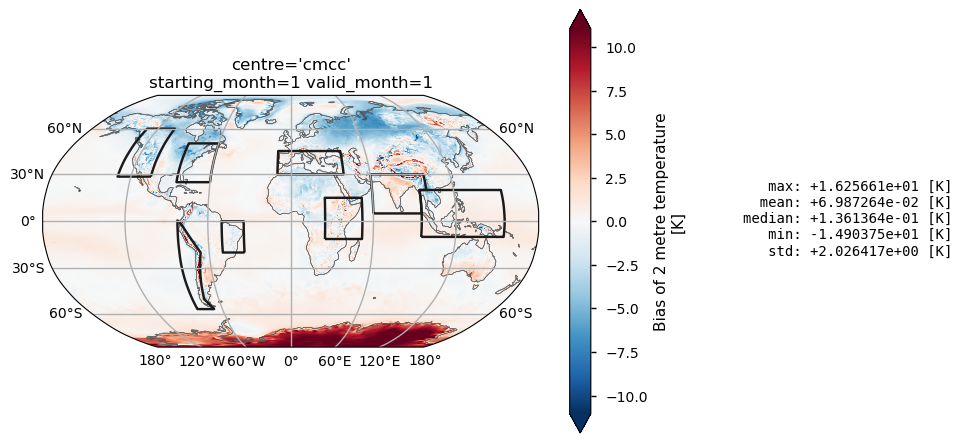

In [6]:
# Set parameters
starting_month = 1
valid_month = 1
variable = "2m_temperature"
centre = "cmcc"
assert all(month in range(1, 13) for month in (starting_month, valid_month))
assert variable in variables
assert centre in centres

# Get reanalysis map
ds = download.download_and_transform(
    collection_id_reanalysis,
    request_reanalysis | {"variable": variable},
    chunks=chunks,
    transform_chunks=False,
    transform_func=diagnostics.monthly_weighted_mean,
)
ds = ds.rename(month="valid_month").sel(valid_month=valid_month)
grid_out = ds[["latitude", "longitude"]]
(da,) = ds.data_vars.values()
da_reanalysis = postprocess_dataarray(da.rename(variable))

# Get seasonal map
ds = download.download_and_transform(
    collection_id_seasonal,
    request_seasonal
    | {"originating_centre": centre, "variable": variable}
    | centres[centre],
    chunks=chunks,
    transform_func=get_seasonal_map,
    transform_func_kwargs={
        "starting_month": starting_month,
        "valid_month": valid_month,
        "grid_out": grid_out,
        "method": "bilinear",
    },
    backend_kwargs={
        "time_dims": (
            "verifying_time",
            ("indexing_time" if centre in ["ukmo", "jma", "ncep"] else "time"),
        )
    },
)
ds = ds.mean("year", keep_attrs=True)
(da,) = ds.data_vars.values()
da_seasonal = postprocess_dataarray(da.rename(variable))

# Compute bias
with xr.set_options(keep_attrs=True):
    bias = da_seasonal - da_reanalysis
bias.attrs["long_name"] = "Bias of " + bias.attrs["long_name"]

# Plot
plot.projected_map(
    bias, projection=ccrs.Robinson(), **plot_kwargs.get(variable, {}) | {"robust": True}
)
regionmask.defined_regions.srex[regions].plot(add_label=False)
_ = plt.title(f"{centre=}\n{starting_month=} {valid_month=}")

## Download and transform ERA5

In [7]:
# Get the reanalysis data
datasets = []
for region in regions:
    dataarrays = []
    for variable in variables:
        print(f"{region=} {variable=}")
        ds = download.download_and_transform(
            collection_id_reanalysis,
            request_reanalysis | {"variable": variable},
            chunks=chunks,
            transform_func=regionalised_spatial_weighted_mean,
            transform_func_kwargs={"region": region, "weights": False},
        )
        (da,) = ds.data_vars.values()
        dataarrays.append(postprocess_dataarray(da.rename(variable)))
    ds = xr.merge(dataarrays)
    datasets.append(ds.expand_dims(region=[region]).compute())
ds_reanalysis = xr.concat(datasets, "region")
del datasets

region='EAF' variable='2m_temperature'


100%|██████████| 24/24 [00:04<00:00,  5.24it/s]


region='EAF' variable='total_precipitation'


100%|██████████| 24/24 [00:03<00:00,  6.07it/s]


region='EAF' variable='surface_solar_radiation_downwards'


100%|██████████| 24/24 [00:03<00:00,  6.18it/s]


region='EAF' variable='10m_wind_speed'


100%|██████████| 24/24 [00:03<00:00,  6.18it/s]


region='EAF' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:03<00:00,  7.60it/s]


region='ENA' variable='2m_temperature'


100%|██████████| 24/24 [00:03<00:00,  6.13it/s]


region='ENA' variable='total_precipitation'


100%|██████████| 24/24 [00:03<00:00,  7.16it/s]


region='ENA' variable='surface_solar_radiation_downwards'


100%|██████████| 24/24 [00:01<00:00, 13.81it/s]


region='ENA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.94it/s]


region='ENA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.66it/s]


region='MED' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.57it/s]


region='MED' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.97it/s]


region='MED' variable='surface_solar_radiation_downwards'


100%|██████████| 24/24 [00:01<00:00, 12.70it/s]


region='MED' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.76it/s]


region='MED' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.49it/s]


region='NEB' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.54it/s]


region='NEB' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.95it/s]


region='NEB' variable='surface_solar_radiation_downwards'


100%|██████████| 24/24 [00:02<00:00, 11.66it/s]


region='NEB' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.52it/s]


region='NEB' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.47it/s]


region='SAS' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.18it/s]


region='SAS' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.36it/s]


region='SAS' variable='surface_solar_radiation_downwards'


100%|██████████| 24/24 [00:01<00:00, 14.21it/s]


region='SAS' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.70it/s]


region='SAS' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.86it/s]


region='SEA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.02it/s]


region='SEA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 15.03it/s]


region='SEA' variable='surface_solar_radiation_downwards'


100%|██████████| 24/24 [00:01<00:00, 12.92it/s]


region='SEA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.64it/s]


region='SEA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.62it/s]


region='WNA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.53it/s]


region='WNA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 14.63it/s]


region='WNA' variable='surface_solar_radiation_downwards'


100%|██████████| 24/24 [00:01<00:00, 14.02it/s]


region='WNA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.70it/s]


region='WNA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.83it/s]


region='WSA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.28it/s]


region='WSA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.74it/s]


region='WSA' variable='surface_solar_radiation_downwards'


100%|██████████| 24/24 [00:01<00:00, 12.50it/s]


region='WSA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.57it/s]


region='WSA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.73it/s]


## Download and transform seasonal forecast

In [8]:
# Get the seasonal forecast data
datasets = []
for centre, request_kwargs in centres.items():
    for region in regions:
        dataarrays = []
        for variable in variables:
            print(f"{centre=} {region=} {variable=}")
            if variable in missing_variables.get(centre, []):
                print("SKIP")
                continue

            ds = download.download_and_transform(
                collection_id_seasonal,
                request_seasonal
                | {"originating_centre": centre, "variable": variable}
                | request_kwargs,
                chunks=chunks,
                transform_func=regionalised_spatial_weighted_mean,
                transform_func_kwargs={
                    "region": region,
                    "weights": False,
                    "mean_dims": ("realization",),
                },
                backend_kwargs={
                    "time_dims": (
                        "verifying_time",
                        (
                            "indexing_time"
                            if centre in ["ukmo", "jma", "ncep"]
                            else "time"
                        ),
                    )
                },
            )
            (da,) = ds.data_vars.values()
            dataarrays.append(postprocess_dataarray(da.rename(variable)))
        ds = xr.merge(dataarrays)
        datasets.append(ds.expand_dims(centre=[centre], region=[region]).compute())
ds_seasonal = xr.merge(datasets)
del datasets

centre='cmcc' region='EAF' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.47it/s]


centre='cmcc' region='EAF' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.62it/s]


ValueError: The truth value of a Array is ambiguous. Use a.any() or a.all().

## Monthly data

In [ ]:
def monthly_mean(ds):
    for dim in ds.dims:
        if "time" in dim:
            ds = (
                ds.groupby(f"{dim}.month")
                .mean(keep_attrs=True)
                .rename(month=dim.replace("time", "month"))
            )
    return ds


ds_reanalysis = monthly_mean(ds_reanalysis)
ds_seasonal = monthly_mean(ds_seasonal)

## Compute bias

In [ ]:
with xr.set_options(keep_attrs=True):
    bias = ds_seasonal - ds_reanalysis
for da in bias.data_vars.values():
    da.attrs["long_name"] = "Bias of " + da.attrs["long_name"]
# Avoid ticks interpolation
bias = bias.assign_coords(
    {name: coord.astype(str) for name, coord in bias.coords.items()}
)

## Plot all biases together

In [ ]:
for varname, da in bias.data_vars.items():
    facet = da.plot(
        col="centre", row="region", x="valid_month", **plot_kwargs.get(varname, {})
    )
    facet.fig.suptitle(f"Seasonal forecast: {da.attrs['long_name']}", y=1.01)
    plt.show()